# Introduction

In this example, we calcuate $f_c(z)$ and compare against figure 22 in *arxiv*:1604.02457.  Therefore we will be studying dark matter decay into photons or electrons over a wide range of injection energy ($E_{inj}$) values.

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

First we set our parameters to the ones used in 1604.02457.

In [2]:
%autoreload
import darkhistory.physics as phys
import numpy as np

In [3]:
%matplotlib inline

In [4]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
import darkhistory.spec.spectools as spectools
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import main

# Specify Model

In [24]:
tau=.5e25

#Annihilation or decay?
inj_particle = 'electron'

#Annihilate/Decay into
inj_type = 'decay'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# Load IDL Files

Here we will download the data used in Fig. 22 of 1604.02457, dubbed the "IDL results" (since the code used to generate this data was written primarily in IDL).

### IDL parameters

Download the parameters used in the IDL files (file can be found at *erebus*@*lns.mit.edu:/zfs/gridgway/transferfuncs/ih_continuous_phot/tf_z_3.000E+03_nstep_6398_logE_1.021E+01_xe_0.000E+00.fits*)

In [25]:
# direc = cwd+'/../../ih_continuous_'+inj_str
user = '/Users/gregoryridgway'
direc = user+'/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'

hdul = fits.open(direc+'elec/tf_z_3.000E+03_nstep_6398_logE_1.067E+01_xe_0.000E+00.fits')
direc = direc+inj_str
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

The input energies used along the x-axis of Fig. 22 in 1604.02457

In [26]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = np.log10(idl_energy[-1])*.99

In [27]:
log10eng[-1]

12.601505994846297

### IDL f(z)'s

Download the f(z)'s generated from IDL (can be found in `erebus:/zfs/gridgway/transferfuncs/ih_continuous_elec_v2/` for electrons and `erebus:/zfs/gridgway/transferfuncs/ih_continuous_phot/` for photons)

In [167]:
float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
f_idl_list = np.zeros((len(log10eng),5,6398))
for i, en in enumerate(log10eng[:-1]):
    hdul = fits.open(
        direc+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
        +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
    )

    data = hdul[1].data

    f_idl_low  = data.field('loweng_deposition_fractions')[0]
    f_idl_high = data.field('higheng_deposition_fractions')[0]
    idl_redshift     = data.field('redshift')[0]

    f_idl_list[i,:] = f_idl_low + f_idl_high
#     f_idl_list[i,:] = f_idl_low
#     f_idl_list[i,:] = f_idl_high
#     f_idl_list[f_idl_list<=0] = 1e-12

    hdul.close()

### Contour Plots

To prove that we have actually downloaded the correct data, we reproduce the contour plots below.  The discrepancies between these contour plots and those in Fig. 22 come from interpolation errors in Fig. 22 that aren't in the below.

In [176]:
def get_fcontour(f_input, inj_type, inj_particle, channel):
    f_for_plot = f_input.copy()
    eng = 10**log10eng
    coarsen_factor=12

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], eng[-1], 5, 2e3])
    print(len(eng))
    print(len(rs_vec))
    print(f_for_plot[:,ind].shape)

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    else:
        if inj_particle == 'phot':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 50, 200])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1, 5, 10,100])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 100, 500])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 100])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 500])
        elif inj_particle == 'elec':
            levels = np.array([1e-3, 1e-2, 1e-1, 3e-1, 1, 10, 100, 1000, 10000, 30000])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 1e-1, 10, 50, 1000])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 5000])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 10, 100, 1000, 10000])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100, 1000, 10000])
                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_vec,
                     np.transpose(f_for_plot[:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.inferno)
#                      cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,rs_vec,
               np.transpose(f_for_plot[:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')
    
#     plt.savefig(
#         cwd+'/../../../f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.png'
#     )
#     plt.savefig(
#         '/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/f_contour/f'+
#         inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )
    plt.show()

40
6398
(40, 6398)


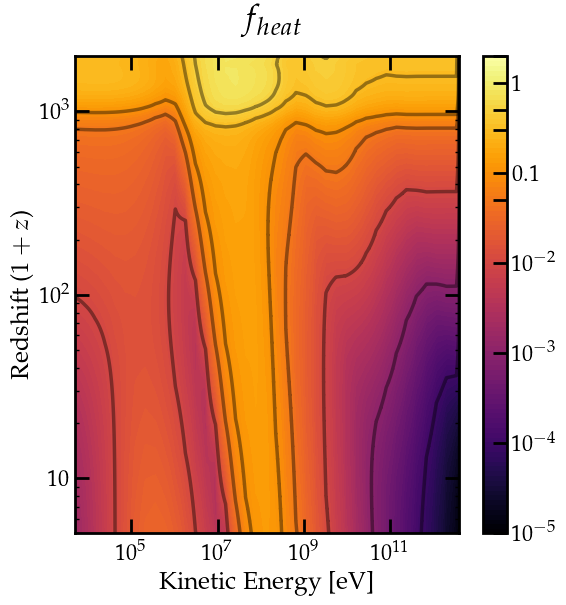

In [86]:
rs_vec = 3000*np.exp(-.001*np.arange(6398))
get_fcontour(f_idl_list, 'decay', 'elec', 'heat')

40
828
(40, 828)


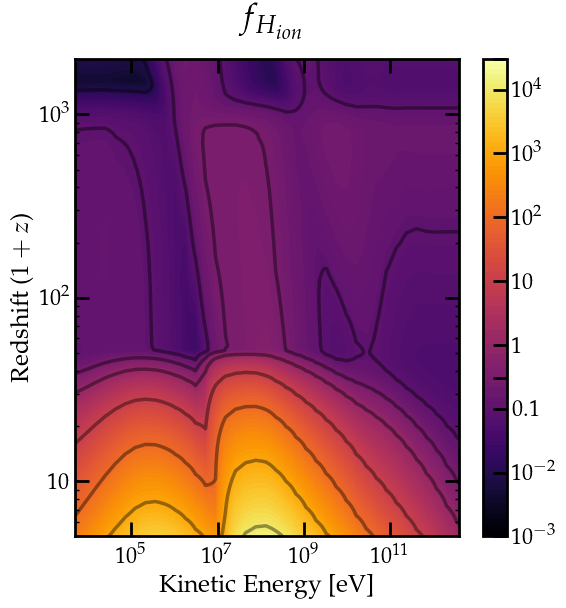

In [179]:
rs_vec = f_DH_data[0]['rs']
get_fcontour(f_DH_list, 'swave', 'elec', 'H_ion')

In [160]:
def get_fdiff(inj_type, inj_particle, channel):
    folder = inj_str+'_'+inj_type+'/'
    
    eng = 10**log10eng   

    rs_list = np.array([3000*np.exp(-0.001*i) for i in np.arange(6398)])

    ind = {'H ion' : 0, 'He ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    f_DH_tmp = f_DH_list[:,ind,:800]

    plt.figure()
    ax=plt.gca()
    ax.loglog()
    levels=[0,.01,.05,.1,.2,.3,.4,.5]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_DH_tmp)
    diffs = np.abs(
        f_DH_tmp - f_idl_list[:,ind,::8]
    )/f_idl_list[:,ind,::8]
    
    cs2 = ax.contourf(eng, rs_list[::8], np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
    cbar = plt.colorbar(cs2, ticks=levels)
    
    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

    plt.savefig(
        '/Users/gregoryridgway/Desktop/April_DH_idl_comparisons/f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs_combined.png'
    )
    plt.show()

#     plt.savefig(
#         cwd+'/../../'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.png'
#     )

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


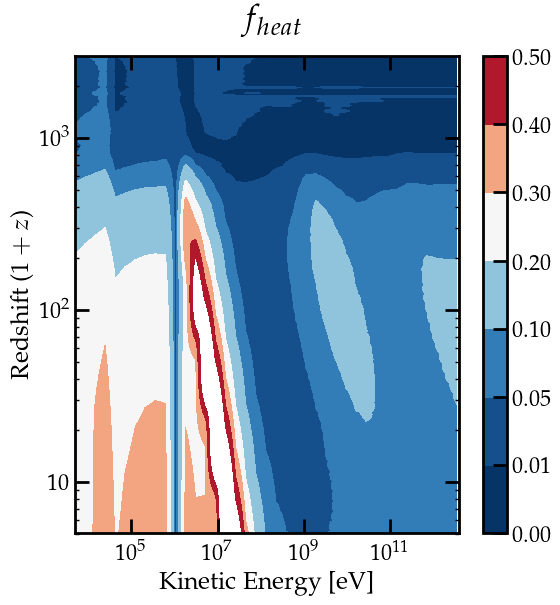

In [172]:
get_fdiff('decay', 'elec', 'heat')

## DH

In [37]:
inj_particle='electron'
inj_type='decay'
inj_str = inj_particle[:4]

In [76]:
f_DH_data = pickle.load(open( 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_v4.p','rb'
                      ))

In [175]:
rs_vec = f_DH_data[0]['rs']
# f_DH_list = np.ones((40,5,len(rs_vec)))*1e-6
f_DH_data = f_DH_data_elec_swave.copy()
tmp=1
tmp2=1
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [(tmp2*f_DH_data[k]['f']['low']['H ion']+tmp*f_DH_data[k]['f']['high']['H ion']),
     (tmp2*f_DH_data[k]['f']['low']['He ion']+tmp*f_DH_data[k]['f']['high']['He ion']),
     (tmp2*f_DH_data[k]['f']['low']['exc']+tmp*f_DH_data[k]['f']['high']['exc']),
     (tmp2*f_DH_data[k]['f']['low']['heat']+tmp*f_DH_data[k]['f']['high']['heat']),
     (tmp2*f_DH_data[k]['f']['low']['cont']+tmp*f_DH_data[k]['f']['high']['cont'])]
)

# f_DH_list = np.swapaxes(f_DH_list,1,2)
f_DH_list[f_DH_list<=0] = 1e-12

In [34]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

# Compute DH f(z)'s

Now we reproduce the above f(z)'s.  We compute the energy deposition history for 40 different DM masses, i.e. 40 different columns of the above plot, each DM mass corresponding to an $E_{inj}$ stored in `log10eng`.

(Description of Tracy's injection of 2+epsilon particles method)

(rate functions in the form of $\frac{\rho (z)}{m_DM}$ for example)

In [35]:
inj_type='decay'
if inj_type == 'decay':
    def struct_boost(rs):
        return 1
else:
    struct_boost = phys.struct_boost_func('einasto_with_subs')

In [323]:
%autoreload

tau=3e27
sigmav=3e-28
def get_column(i, f_DH_list, inj_particle='electron', inj_type='decay', end_rs=4.004):
    """ Produce one column of the f differential plot
    """
    #injection energy, DM mass, center-of-mass energy
    Einj = 10**log10eng[i]
    mDM = 2*Einj + 2*mass
    Ecom=mDM
    
    if inj_type == 'decay':
        def struct_boost(rs):
            return 1
    else:
        def struct_boost(rs):
            return 1
#         struct_boost = phys.struct_boost_func('einasto_with_subs')
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
    
    if inj_type == 'swave':
        mDM = mDM/2
        Ecom = 2*mDM   
    

    if inj_particle == 'photon':
        primary = 'phot_delta'
        coarsen_factor = 1
    else:
        primary = 'elec_delta'
        coarsen_factor = 8
    
    f_DH_list[i] = main.evolve(
        primary=primary,
        rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
        DM_process=inj_type, mDM=mDM, sigmav=sigmav, lifetime=tau,
        start_rs = 3000, end_rs=end_rs,
        coarsen_factor=coarsen_factor, backreaction=False,
        struct_boost=struct_boost
    )

In [113]:
%autoreload
inj_type='decay'
inj_particle='electron'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

# f_DH_data = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    if k==10:
        print('starting run ', k)
        get_column(k, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

# save_as_pickled_object(f_DH_data, 
#             '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
#                        +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_v4.p'
#                       )

starting run  10


In [173]:
%autoreload 2
inj_type='swave'
inj_particle='electron'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

f_DH_data_elec_swave = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    get_column(k, f_DH_data_elec_swave, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

save_as_pickled_object(f_DH_data_elec_swave, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_v4.p'
                      )

starting run  0


starting run  1


starting run  2


starting run  3


starting run  4


starting run  5


starting run  6


starting run  7


starting run  8


starting run  9


starting run  10


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


starting run  11


starting run  12


starting run  13


starting run  14


starting run  15


starting run  16


starting run  17


starting run  18


starting run  19


starting run  20


starting run  21


starting run  22


starting run  23


starting run  24


starting run  25


starting run  26


starting run  27


starting run  28


starting run  29


starting run  30


starting run  31


starting run  32


starting run  33


starting run  34


starting run  35


starting run  36


starting run  37


starting run  38


starting run  39


In [348]:
phys.f_std(5e3, rs_vec, inj_particle='elec', inj_type='swave', struct=False, channel='H ion')

array([1.07770121e-05, 2.32695997e-02, 3.16277991e-02, 3.35403142e-02,
       3.35050533e-02, 3.28798637e-02, 3.20678406e-02, 3.11890298e-02,
       3.02801947e-02, 2.94053723e-02, 2.87025085e-02, 2.80050972e-02,
       2.72984444e-02, 2.65829636e-02, 2.58586735e-02, 2.51254361e-02,
       2.43830473e-02, 2.36312757e-02, 2.30522640e-02, 2.24910251e-02,
       2.19229986e-02, 2.13475207e-02, 2.07645928e-02, 2.01741518e-02,
       1.95761185e-02, 1.89704116e-02, 1.84621877e-02, 1.80077456e-02,
       1.75517979e-02, 1.70899130e-02, 1.66221932e-02, 1.61486313e-02,
       1.56691767e-02, 1.51837596e-02, 1.47434821e-02, 1.43796851e-02,
       1.40182627e-02, 1.36521534e-02, 1.32814681e-02, 1.29062093e-02,
       1.25263396e-02, 1.21418005e-02, 1.17656478e-02, 1.14788624e-02,
       1.11971284e-02, 1.09117242e-02, 1.06227740e-02, 1.03303028e-02,
       1.00342910e-02, 9.73470159e-03, 9.43148920e-03, 9.21169212e-03,
       9.01226366e-03, 8.81207701e-03, 8.60996424e-03, 8.40597650e-03,
      

In [341]:
np.flipud(f_DH_list[0][:,0])/phys.f_std(5e3,rs_vec,inj_particle='elec',inj_type='swave',struct=False,channel='H ion')

array([0.99970306, 0.99999961, 0.99999969, 0.9999997 , 0.9999997 ,
       0.9999997 , 0.9999997 , 0.9999997 , 0.99999969, 0.99999969,
       0.99999968, 0.99999968, 0.99999967, 0.99999967, 0.99999966,
       0.99999965, 0.99999964, 0.99999963, 0.99999963, 0.99999962,
       0.99999961, 0.9999996 , 0.99999958, 0.99999957, 0.99999956,
       0.99999954, 0.99999953, 0.99999951, 0.9999995 , 0.99999948,
       0.99999946, 0.99999944, 0.99999942, 0.9999994 , 0.99999938,
       0.99999935, 0.99999933, 0.99999931, 0.99999928, 0.99999925,
       0.99999922, 0.99999918, 0.99999915, 0.99999911, 0.99999908,
       0.99999904, 0.999999  , 0.99999895, 0.9999989 , 0.99999884,
       0.99999878, 0.99999873, 0.99999867, 0.9999986 , 0.99999853,
       0.99999846, 0.99999838, 0.99999829, 0.99999819, 0.9999981 ,
       0.99999802, 0.99999793, 0.99999784, 0.99999776, 0.99999768,
       0.99999761, 0.99999754, 0.99999747, 0.99999741, 0.99999735,
       0.99999728, 0.99999721, 0.99999714, 0.99999706, 0.99999

In [324]:
%autoreload 2
inj_type='swave'
inj_particle='electron'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

f_DH_data_elec_swave = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    get_column(k, f_DH_data_elec_swave, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

save_as_pickled_object(f_DH_data_elec_swave, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_noStructure_v4.p'
                      )

starting run  0
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


starting run  1


starting run  2


starting run  3


starting run  4


starting run  5


starting run  6


starting run  7


starting run  8


starting run  9


starting run  10


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


starting run  11


starting run  12


starting run  13


starting run  14


starting run  15


starting run  16


starting run  17


starting run  18


starting run  19


starting run  20


starting run  21


starting run  22


starting run  23


starting run  24


starting run  25


starting run  26


starting run  27


starting run  28


starting run  29


starting run  30


starting run  31


starting run  32


starting run  33


starting run  34


starting run  35


starting run  36


starting run  37


starting run  38


starting run  39


# Plot f contours

To see the level of discrepancy between the two data sets, is useful to plot the absolute residual difference between the two sets of f(z)'s.  We will find that we do better than 10% accuracy for essentially all of the data.

In [235]:
f_DH_list = np.ones((40,5,round(552)))*1e-6
tmp=1
# f_DH_data = f_DH_data_elec_swave
for k in np.arange(40):
#     if k<4:
    f_DH_list[k] = np.array(
        [f_DH_data[k]['f']['low']['H ion']+tmp*f_DH_data[k]['f']['high']['H ion'],
         f_DH_data[k]['f']['low']['He ion']+tmp*f_DH_data[k]['f']['high']['He ion'],
         f_DH_data[k]['f']['low']['exc']+tmp*f_DH_data[k]['f']['high']['exc'],
         f_DH_data[k]['f']['low']['heat']+tmp*f_DH_data[k]['f']['high']['heat'],
         f_DH_data[k]['f']['low']['cont']+tmp*f_DH_data[k]['f']['high']['cont']]
    )


40
828
(40, 828)


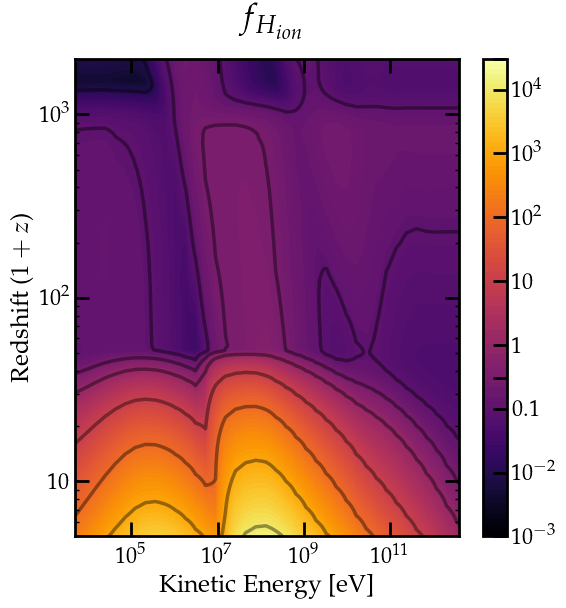

In [201]:
get_fcontour(f_DH_list, 'swave', 'elec', 'H_ion')

# Standard $f_c(z,E_\text{inj})$ grid values

In [353]:
f_DH_data_elec_swave[0]['f']['low']['H ion']+f_DH_data_elec_swave[0]['f']['high']['H ion']

array([1.07738120e-05, 2.32695906e-02, 3.16277892e-02, 3.35403042e-02,
       3.35050434e-02, 3.28798539e-02, 3.20678310e-02, 3.11890204e-02,
       3.02801854e-02, 2.94053632e-02, 2.87024994e-02, 2.80050882e-02,
       2.72984355e-02, 2.65829547e-02, 2.58586647e-02, 2.51254274e-02,
       2.43830387e-02, 2.36312670e-02, 2.30522554e-02, 2.24910164e-02,
       2.19229900e-02, 2.13475120e-02, 2.07645842e-02, 2.01741431e-02,
       1.95761098e-02, 1.89704029e-02, 1.84621790e-02, 1.80077368e-02,
       1.75517890e-02, 1.70899041e-02, 1.66221843e-02, 1.61486223e-02,
       1.56691676e-02, 1.51837505e-02, 1.47434729e-02, 1.43796758e-02,
       1.40182533e-02, 1.36521439e-02, 1.32814585e-02, 1.29061997e-02,
       1.25263298e-02, 1.21417906e-02, 1.17656378e-02, 1.14788522e-02,
       1.11971181e-02, 1.09117137e-02, 1.06227633e-02, 1.03302919e-02,
       1.00342799e-02, 9.73469033e-03, 9.43147772e-03, 9.21168038e-03,
       9.01225164e-03, 8.81206470e-03, 8.60995162e-03, 8.40596354e-03,
      

In [356]:
np.flipud(f_DH_list[0][:,0])

array([1.07738120e-05, 2.32695906e-02, 3.16277892e-02, 3.35403042e-02,
       3.35050434e-02, 3.28798539e-02, 3.20678310e-02, 3.11890204e-02,
       3.02801854e-02, 2.94053632e-02, 2.87024994e-02, 2.80050882e-02,
       2.72984355e-02, 2.65829547e-02, 2.58586647e-02, 2.51254274e-02,
       2.43830387e-02, 2.36312670e-02, 2.30522554e-02, 2.24910164e-02,
       2.19229900e-02, 2.13475120e-02, 2.07645842e-02, 2.01741431e-02,
       1.95761098e-02, 1.89704029e-02, 1.84621790e-02, 1.80077368e-02,
       1.75517890e-02, 1.70899041e-02, 1.66221843e-02, 1.61486223e-02,
       1.56691676e-02, 1.51837505e-02, 1.47434729e-02, 1.43796758e-02,
       1.40182533e-02, 1.36521439e-02, 1.32814585e-02, 1.29061997e-02,
       1.25263298e-02, 1.21417906e-02, 1.17656378e-02, 1.14788522e-02,
       1.11971181e-02, 1.09117137e-02, 1.06227633e-02, 1.03302919e-02,
       1.00342799e-02, 9.73469033e-03, 9.43147772e-03, 9.21168038e-03,
       9.01225164e-03, 8.81206470e-03, 8.60995162e-03, 8.40596354e-03,
      

In [287]:
inj_particle='electron'
inj_type='swave'
inj_str = inj_particle[:4]

In [288]:
f_DH_data = pickle.load(open( 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_v4.p','rb'
                      ))

In [354]:
rs_vec = f_DH_data[0]['rs']
f_DH_list = np.ones((40,5,len(rs_vec)))*1e-6
f_DH_data = f_DH_data_elec_swave.copy()
tmp=1
tmp2=1
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [np.flipud(tmp2*f_DH_data[k]['f']['low']['H ion']+tmp*f_DH_data[k]['f']['high']['H ion']),
     np.flipud(tmp2*f_DH_data[k]['f']['low']['He ion']+tmp*f_DH_data[k]['f']['high']['He ion']),
     np.flipud(tmp2*f_DH_data[k]['f']['low']['exc']+tmp*f_DH_data[k]['f']['high']['exc']),
     np.flipud(tmp2*f_DH_data[k]['f']['low']['heat']+tmp*f_DH_data[k]['f']['high']['heat']),
     np.flipud(tmp2*f_DH_data[k]['f']['low']['cont']+tmp*f_DH_data[k]['f']['high']['cont'])]
)

f_DH_list = np.swapaxes(f_DH_list,1,2)
f_DH_list[f_DH_list<=0] = 1e-12

In [366]:
f_DH_list[0][:,0]

array([1.82396515e-01, 1.81459256e-01, 1.80519440e-01, 1.79577217e-01,
       1.78632729e-01, 1.77686117e-01, 1.76737512e-01, 1.75787045e-01,
       1.74834839e-01, 1.73881014e-01, 1.72925685e-01, 1.71968963e-01,
       1.71010955e-01, 1.70051763e-01, 1.69091486e-01, 1.68130217e-01,
       1.67238561e-01, 1.66426973e-01, 1.65612268e-01, 1.64794593e-01,
       1.63974098e-01, 1.63150923e-01, 1.62325204e-01, 1.61497075e-01,
       1.60666662e-01, 1.59834090e-01, 1.58999477e-01, 1.58162939e-01,
       1.57324273e-01, 1.56483705e-01, 1.55641539e-01, 1.54797872e-01,
       1.53952800e-01, 1.53240681e-01, 1.52538498e-01, 1.51832888e-01,
       1.51123997e-01, 1.50411969e-01, 1.49696941e-01, 1.48979048e-01,
       1.48258420e-01, 1.47535180e-01, 1.46809452e-01, 1.46081353e-01,
       1.45350995e-01, 1.44618489e-01, 1.43883940e-01, 1.43147451e-01,
       1.42409118e-01, 1.41721084e-01, 1.41122445e-01, 1.40519669e-01,
       1.39913130e-01, 1.39303031e-01, 1.38689512e-01, 1.38072707e-01,
      

In [364]:
f_DH_list2 = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                           inj_str+'_'+inj_type+'_std.p','rb'))

In [367]:
pickle.dump(f_DH_list,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                           inj_str+'_'+inj_type+'_std.p','wb'))

In [369]:
inj_type

'swave'

In [218]:
if inj_type == 'swave':
    pickle.dump(f_DH_list,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                               inj_str+'_'+inj_type+'_std_einasto_subs.p','wb'))
else:
    pickle.dump(f_DH_list,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                               inj_str+'_'+inj_type+'_std.p','wb'))

Remember to:

    (1) Change back to DH parameters instead of IDL parameters (H0, etc.)
    (2) sum over partial bins (in the low energy electron methods)
    (3) off-by-one in the CMB subtraction